In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
import xgboost as xgb

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from tqdm import tqdm
import swifter

import string
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from textatistic import Textatistic
from LeXmo import LeXmo
import emot
import nrclex
from language_tool_python import LanguageTool

import matplotlib.pyplot as plt
import seaborn as sns

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
tqdm.pandas()
nlp = spacy.load("en_core_web_sm")
spell = SpellChecker()
tool = LanguageTool('en-US')
#lemmatizer = WordNetLemmatizer()
STOP_WORDS = stopwords.words('english')
PUNCT_MARKS = list(string.punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\osjom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("train_features2.csv")
df2 = df.drop(["discourse_id","essay_id"], axis=1)

one_hot_encoded = pd.get_dummies(df['discourse_type'], drop_first=True)
df2 = pd.concat([df2, one_hot_encoded], axis=1)

labels = {
    'Ineffective': 0,
    'Adequate': 1,
    'Effective': 2
}

X = df2.drop(["discourse_effectiveness"], axis=1)
y = df2['discourse_effectiveness'].map(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
df2.head()

,discourse_text,discourse_type,discourse_effectiveness,spelling_errors,grammar_errors,punctuation_marks,text_length,sent_count,word_count,sybl_count,...,noun_phrases_prop,chars_per_word,words_per_sentence,sybl_per_sentence,Concluding Statement,Counterclaim,Evidence,Lead,Position,Rebuttal
0,hi i am isaac i am going to be writing about h...,Lead,Adequate,7,2,9,325,3.0,70.0,81.0,...,0.105263,3.571429,23.333333,27.00,0,0,0,1,0,0
1,on my perspective i think that the face is a n...,Position,Adequate,4,2,4,214,2.0,42.0,53.0,...,0.127660,4.047619,21.000000,26.50,0,0,0,0,1,0
2,i think that the face is a natural landlord be...,Claim,Adequate,2,1,0,105,1.0,21.0,27.0,...,0.136364,4.047619,21.000000,27.00,0,0,0,0,0,0
3,if life wa on mar we would know by now the rea...,Evidence,Adequate,11,3,13,374,4.0,76.0,99.0,...,0.058824,3.815789,19.000000,24.75,0,0,1,0,0,0
4,people thought that the face wa formed by alie...,Counterclaim,Adequate,2,1,1,100,1.0,18.0,20.0,...,0.052632,4.555556,18.000000,20.00,0,1,0,0,0,0


In [4]:
types_dict = {
    'Evidence': (3896, 696),
    'Claim': (641, 117),
    'Position': (517, 99),
    'Concluding Statement': (1454, 259),
    'Lead': (1700, 316),
    'Counterclaim': (1282, 217),
    'Rebuttal': (944, 175)
}

X_train_types = []
y_train_types = []
X_test_types = []
y_test_types = []

for discourse_type, (maxlen, max_words) in types_dict.items():
    X_train_type = X_train[X_train.discourse_type == discourse_type].drop('discourse_type', axis=1)
    y_train_type = y_train[X_train.discourse_type == discourse_type]

    X_test_type = X_test[X_test.discourse_type == discourse_type].drop('discourse_type', axis=1)
    y_test_type = y_test[X_test.discourse_type == discourse_type]

    discourse_type = discourse_type.replace(' ', '')
    
    with open('models/tokenizer_' + discourse_type + '.json', 'r', encoding='utf-8') as json_file:
        tokenizer_json = json_file.read()

    tokenizer = tokenizer_from_json(tokenizer_json)
    
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_type['discourse_text']), maxlen=maxlen)
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_type['discourse_text']), maxlen=maxlen)
    
    model_conv = load_model('models/conv_' + discourse_type +'.h5')
    
    X_train_features = X_train_type.drop("discourse_text", axis=1)
    X_test_features = X_test_type.drop("discourse_text", axis=1)
    
    X_train_features[['prob_0_conv', 'prob_1_conv', 'prob_2_conv']] = model_conv.predict(X_train_seq)
    X_test_features[['prob_0_conv', 'prob_1_conv', 'prob_2_conv']] = model_conv.predict(X_test_seq)
    
    X_train_types.append(X_train_features.copy())
    y_train_types.append(y_train_type.copy())
    
    X_test_types.append(X_test_features.copy())
    y_test_types.append(y_test_type.copy())

X_train_all = pd.concat(X_train_types, axis=0)
y_train_all = pd.concat(y_train_types, axis=0)

X_test_all = pd.concat(X_test_types, axis=0)
y_test_all = pd.concat(y_test_types, axis=0)

predictions_conv = np.argmax(X_test_all[['prob_0_conv', 'prob_1_conv', 'prob_2_conv']].values, axis=1)
print(classification_report(y_test_all, predictions_conv, zero_division=np.nan))

8/8 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.57      0.13      0.21      1282
           1       0.64      0.87      0.74      4246
           2       0.64      0.46      0.53      1825

    accuracy                           0.64      7353
   macro avg       0.62      0.49      0.50      7353
weighted avg       0.63      0.64      0.60      7353



In [6]:
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    seed=42,
    learning_rate=0.1,
    max_bins=200,
    min_child_weight=200,
    max_depth=10,
    n_estimators=50
)
model_xgb.fit(X_train_all, y_train_all)
predictions_xgb = model_xgb.predict(X_test_all)
probs_xgb = model_xgb.predict_proba(X_test_all)
print(classification_report(y_train_all, model_xgb.predict(X_train_all), zero_division=np.nan))
print(classification_report(y_test_all, predictions_xgb, zero_division=np.nan))

C:\Users\osjom\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_bins" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.68      0.30      0.42      5180
           1       0.71      0.88      0.78     16731
           2       0.77      0.66      0.71      7501

    accuracy                           0.72     29412
   macro avg       0.72      0.61      0.64     29412
weighted avg       0.72      0.72      0.70     29412

              precision    recall  f1-score   support

           0       0.54      0.23      0.32      1282
           1       0.67      0.83      0.74      4246
           2       0.65      0.54      0.59      1825

    accuracy                           0.65      7353
   macro avg       0.62      0.53      0.55      7353
weighted avg       0.64      0.65      0.63      7353



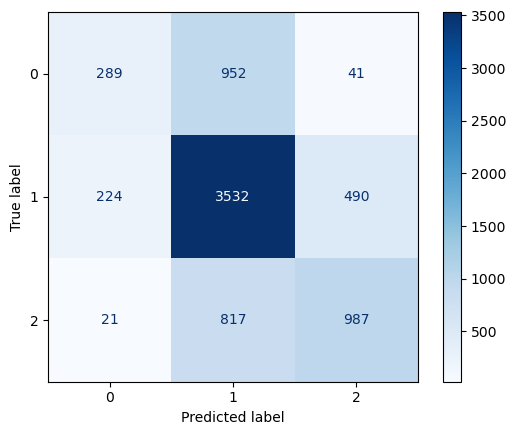

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test_all, predictions_xgb, cmap='Blues')
plt.show()

In [8]:
def custom_thresholds(predictions, threshold_0, threshold_2):
    final_predictions = np.ones(predictions.shape[0], dtype=int)
    final_predictions[predictions[:, 0] > threshold_0] = 0
    final_predictions[predictions[:, 2] > threshold_2] = 2

    return final_predictions

              precision    recall  f1-score   support

           0       0.43      0.42      0.42      1282
           1       0.68      0.68      0.68      4246
           2       0.60      0.60      0.60      1825

    accuracy                           0.62      7353
   macro avg       0.57      0.57      0.57      7353
weighted avg       0.62      0.62      0.62      7353



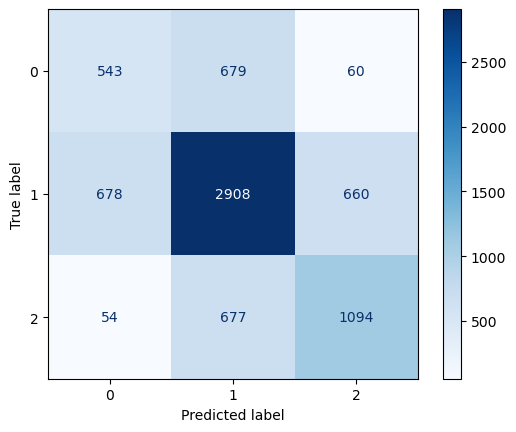

In [9]:
thresh_probs = custom_thresholds(probs_xgb, 0.31, 0.39)

print(classification_report(y_test_all, thresh_probs, zero_division=np.nan))

ConfusionMatrixDisplay.from_predictions(y_test_all, thresh_probs, cmap='Blues')
plt.show()

In [10]:
print(y_test_all.value_counts())
print(pd.Series(predictions_xgb).value_counts())
print(pd.Series(thresh_probs).value_counts())

1    4246
2    1825
0    1282
Name: discourse_effectiveness, dtype: int64
1    5301
2    1518
0     534
dtype: int64
1    4264
2    1814
0    1275
dtype: int64


In [12]:
def spelling_errors(text):
    words = text.split()
    misspelled = spell.unknown(words)
    return len(misspelled)

def grammar_errors(text):
    matches = tool.check(text)
    return len(matches)

def punctuation_marks(text):
    return sum([1 for char in text if char in PUNCT_MARKS])

contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

def handle_contractions(text):
    words = word_tokenize(text)
    words = [contractions[word] if word in contractions else word for word in words]
    return ' '.join(words)

def spell_correction(text):
    words = word_tokenize(text)
    corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
    return ' '.join(corrected_words)

def end_sentence(text):
    if text[-1] not in ['!', '?', '.']:
        return text + '.'
    return text

def readability_features(text):
    s = Textatistic(text)
    return pd.Series([s.sent_count, s.word_count, s.sybl_count, s.char_count, s.polysyblword_count, s.dalechall_score,
                      s.flesch_score, s.fleschkincaid_score, s.gunningfog_score, s.smog_score])

def avg_word_length(text):
    words = text.split()
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    return(avg_word_length)

def stop_words(text):
    words = text.split()
    return sum(1 for word in words if word.lower() in STOP_WORDS)

def lexical_types(text):
    words = word_tokenize(text)
    lexical_types = set(words)
    return len(lexical_types)

def syntatic_complexity_features(text):
    doc = nlp(text)
    total_tokens = len(doc)
    num_clauses = len([token for token in doc if token.dep_ == "ROOT"])
    num_sub_clauses = len([token for token in doc if token.dep_ == "acl" or token.dep_ == "advcl"])
    num_verb_phrases = len([chunk for chunk in doc.noun_chunks if chunk.root.pos_ == "VERB"])
    num_complex_noun_phrases = len([chunk for chunk in doc.noun_chunks if len(chunk) > 1])

    return pd.Series([num_clauses / total_tokens, num_sub_clauses / total_tokens, num_verb_phrases / total_tokens,
                      num_complex_noun_phrases / total_tokens])

def remove_stop_words(text):
    removed_stop_words = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return removed_stop_words

def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [ ]:
def predict(text, discourse_type):
    data = pd.DataFrame({
        'discourse_text': [text],
        'discourse_type': [discourse_type]
    })
    
    # Fase 1
    data['spelling_errors'] = data['discourse_text'].apply(spelling_errors)
    data['grammar_errors'] = data['discourse_text'].apply(grammar_errors)
    data['punctuation_marks'] = data['discourse_text'].apply(punctuation_marks)
    
    # Fase 2
    data['discourse_text'] = data['discourse_text'].apply(handle_contractions)
    data['discourse_text'] = data['discourse_text'].apply(spell_correction)
    data['discourse_text'] = data['discourse_text'].apply(end_sentence)
    data['discourse_text'] = data['discourse_text'].str.lower()
    
    # Fase 3
    data['text_length'] = data['discourse_text'].apply(len)
    data[['sent_count', 'word_count', 'sybl_count', 'char_count', 
          'polysyblword_count', 'dalechall_score', 'flesch_score',
         'fleschkincaid_score', 'gunningfog_score', 'smog_score']] = data['discourse_text'].apply(readability_features)
    data['stop_words'] = data['discourse_text'].apply(stop_words)
    data['lexical_types'] = data['discourse_text'].apply(lexical_types)
    data[['clauses_prop', 'sub_clauses_prop', 
          'verb_phrases_prop', 'noun_phrases_prop']] = data['discourse_text'].apply(syntatic_complexity_features)
    data['chars_per_word'] = data['char_count'] / data['word_count']
    data['words_per_sentence'] = data['word_count'] / data['sent_count']
    data['sybl_per_sentence'] = data['sybl_count'] / data['sent_count'] 
    
    # Fase 4
    data['discourse_text'] = data['discourse_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    data['discourse_text'] = data['discourse_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    data['discourse_text'] = data['discourse_text'].swifter.apply(lemmatize_text)
    
    # Modelo
    discourse_type = discourse_type.replace(' ', '')
    
    with open('models/tokenizer_' + discourse_type + '.json', 'r', encoding='utf-8') as json_file:
        tokenizer_json = json_file.read()

    tokenizer = tokenizer_from_json(tokenizer_json)
    
    data_seq = pad_sequences(tokenizer.texts_to_sequences(data['discourse_text']), maxlen=maxlen)
    
    model_conv = load_model('models/conv_' + discourse_type +'.h5')
    
    data_features = data.drop("discourse_text", axis=1)
    
    data_features[['prob_0_conv', 'prob_1_conv', 'prob_2_conv']] = model_conv.predict(data_seq)
    
    

In [13]:
df2.head()

,discourse_text,discourse_type,discourse_effectiveness,spelling_errors,grammar_errors,punctuation_marks,text_length,sent_count,word_count,sybl_count,...,noun_phrases_prop,chars_per_word,words_per_sentence,sybl_per_sentence,Concluding Statement,Counterclaim,Evidence,Lead,Position,Rebuttal
0,hi i am isaac i am going to be writing about h...,Lead,Adequate,7,2,9,325,3.0,70.0,81.0,...,0.105263,3.571429,23.333333,27.00,0,0,0,1,0,0
1,on my perspective i think that the face is a n...,Position,Adequate,4,2,4,214,2.0,42.0,53.0,...,0.127660,4.047619,21.000000,26.50,0,0,0,0,1,0
2,i think that the face is a natural landlord be...,Claim,Adequate,2,1,0,105,1.0,21.0,27.0,...,0.136364,4.047619,21.000000,27.00,0,0,0,0,0,0
3,if life wa on mar we would know by now the rea...,Evidence,Adequate,11,3,13,374,4.0,76.0,99.0,...,0.058824,3.815789,19.000000,24.75,0,0,1,0,0,0
4,people thought that the face wa formed by alie...,Counterclaim,Adequate,2,1,1,100,1.0,18.0,20.0,...,0.052632,4.555556,18.000000,20.00,0,1,0,0,0,0
